In [31]:
# Importing the required libraries
import numpy as np
import pandas as pd
import mlflow
import mlflow.sklearn
from math import log2, sqrt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.fft import fft, ifft
from scipy.special import erfc
from pydotplus import graph_from_dot_data
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt



In [32]:
import numpy as np
import pandas as pd
from math import log2, sqrt
from scipy.fft import fft
from scipy.special import erfc
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE

# Concatenate data
def concatenateData(df, num_concats):
    new_df = pd.DataFrame({
        'Concatenated_Data': [''] * (len(df) // num_concats), 
        'label': [0] * (len(df) // num_concats)
    })

    # Loop through each group of num_concats rows and concatenate their 'binary_number' strings
    for i in range(0, len(df), num_concats):
        new_df.iloc[i // num_concats, 0] = ''.join(df['binary_number'][i:i + num_concats])
        new_df.iloc[i // num_concats, 1] = df['label'][i]

    return new_df

def shannon_entropy(binary_string):
    if len(binary_string) % 2 != 0:
        raise ValueError("Binary string length must be a multiple of 2.")
    
    patterns = ['00', '10', '11', '01']
    frequency = {pattern: 0 for pattern in patterns}
    
    for i in range(0, len(binary_string), 2):
        segment = binary_string[i:i+2]
        if segment in patterns:
            frequency[segment] += 1
    
    total_segments = sum(frequency.values())
    
    entropy = 0
    for count in frequency.values():
        if count > 0:
            probability = count / total_segments
            entropy -= probability * log2(probability)
    
    return entropy


def classic_spectral_test(bit_string):
    bit_array = 2 * np.array([int(bit) for bit in bit_string]) - 1
    dft = fft(bit_array)
    n_half = len(bit_string) // 2 + 1
    mod_dft = np.abs(dft[:n_half])
    threshold = np.sqrt(np.log(1 / 0.05) / len(bit_string))
    peaks_below_threshold = np.sum(mod_dft < threshold)
    expected_peaks = 0.95 * n_half
    d = (peaks_below_threshold - expected_peaks) / np.sqrt(len(bit_string) * 0.95 * 0.05)
    p_value = erfc(np.abs(d) / np.sqrt(2)) / 2
    return d

def frequency_test(bit_string):
    n = len(bit_string)
    count_ones = bit_string.count('1')
    count_zeros = bit_string.count('0')
    
    # The test statistic
    s = (count_ones - count_zeros) / sqrt(n)
    
    # The p-value
    p_value = erfc(abs(s) / sqrt(2))
    
    return p_value

def runs_test(bit_string):
    n = len(bit_string)
    runs = 1  # Start with the first run
    for i in range(1, n):
        if bit_string[i] != bit_string[i - 1]:
            runs += 1
    
    n0 = bit_string.count('0')
    n1 = bit_string.count('1')
    
    # Expected number of runs
    expected_runs = (2 * n0 * n1 / n) + 1
    variance_runs = (2 * n0 * n1 * (2 * n0 * n1 - n)) / (n ** 2 * (n - 1))
    
    # The test statistic
    z = (runs - expected_runs) / sqrt(variance_runs)
    
    # The p-value
    p_value = erfc(abs(z) / sqrt(2))
    
    return p_value

def linear_complexity(bit_string, M=500):
    # Perform linear complexity test with block size M
    n = len(bit_string)
    bit_array = np.array([int(bit) for bit in bit_string])
    lc = 0  # Initialize linear complexity
    
    # Process blocks of size M
    for i in range(0, n, M):
        block = bit_array[i:i+M]
        if len(block) < M:
            continue
        
        lc_block = 0
        for j in range(M):
            if block[j] == 1:
                lc_block = j + 1
        
        lc += lc_block
    
    lc = lc / (n / M)
    return lc

def autocorrelation_test(bit_string, lag=1):
    n = len(bit_string)
    bit_array = np.array([int(bit) for bit in bit_string])
    autocorrelation = np.correlate(bit_array, np.roll(bit_array, lag), mode='valid')[0]
    return autocorrelation / n

def maurer_universal_test(bit_string):
    k = 6
    l = 5
    q = 20
    bit_array = np.array([int(bit) for bit in bit_string])
    max_val = 2**k
    init_subseq = bit_array[:q]
    rest_subseq = bit_array[q:]
    d = {}
    for i in range(len(init_subseq) - k + 1):
        d[tuple(init_subseq[i:i+k])] = i
    t = []
    for i in range(len(rest_subseq) - k + 1):
        subseq = tuple(rest_subseq[i:i+k])
        if subseq in d:
            t.append(i - d[subseq])
            d[subseq] = i
    if not t:
        return 0
    t = np.array(t)
    log_avg = np.mean(np.log2(t))
    return log_avg - np.log2(q)

def binary_matrix_rank_test(bit_string, M=32, Q=32):
    bit_array = np.array([int(bit) for bit in bit_string])
    num_matrices = len(bit_array) // (M * Q)
    ranks = []
    for i in range(num_matrices):
        matrix = bit_array[i*M*Q:(i+1)*M*Q].reshape((M, Q))
        rank = np.linalg.matrix_rank(matrix)
        ranks.append(rank)
    return np.mean(ranks)

def cumulative_sums_test(bit_string):
    bit_array = np.array([int(bit) for bit in bit_string])
    adjusted = 2 * bit_array - 1
    cumulative_sum = np.cumsum(adjusted)
    max_excursion = np.max(np.abs(cumulative_sum))
    return max_excursion

def longest_run_ones_test(bit_string, block_size=100):
    bit_array = np.array([int(bit) for bit in bit_string])
    num_blocks = len(bit_array) // block_size
    max_runs = []
    for i in range(num_blocks):
        block = bit_array[i*block_size:(i+1)*block_size]
        max_run = max([len(list(g)) for k, g in itertools.groupby(block) if k == 1])
        max_runs.append(max_run)
    return np.mean(max_runs)

def random_excursions_test(bit_string):
    bit_array = np.array([int(bit) for bit in bit_string])
    bit_array = 2 * bit_array - 1  # Convert to ±1

    cumulative_sum = np.cumsum(bit_array)
    states = np.unique(cumulative_sum)

    if 0 not in states:
        states = np.append(states, 0)
    state_counts = {state: 0 for state in states}
    for state in cumulative_sum:
        state_counts[state] += 1

    state_counts[0] -= 1  # Adjust for zero state
    pi = [0.5 * (1 - (1 / (2 * state + 1)**2)) for state in states]
    x = np.sum([(state_counts[state] - len(bit_string) * pi[i])**2 / (len(bit_string) * pi[i]) for i, state in enumerate(states)])

    return x


def unique_subsequences(bit_string, length=4):
    bit_array = np.array([int(bit) for bit in bit_string])
    n = len(bit_array)
    subsequences = set()
    
    for i in range(n - length + 1):
        subseq = tuple(bit_array[i:i+length])
        subsequences.add(subseq)
    
    return len(subsequences)

def sample_entropy(bit_string, m=2, r=0.2):
    bit_array = np.array([int(bit) for bit in bit_string])
    N = len(bit_array)
    
    def _phi(m):
        x = np.array([bit_array[i:i+m] for i in range(N - m + 1)])
        C = np.sum(np.all(np.abs(x[:, None] - x) <= r, axis=2), axis=0) / (N - m + 1.0)
        return np.sum(C) / (N - m + 1.0)
    
    return -np.log(_phi(m + 1) / _phi(m))

def permutation_entropy(bit_string, order=3):
    bit_array = np.array([int(bit) for bit in bit_string])
    n = len(bit_array)
    
    permutations = np.array(list(itertools.permutations(range(order))))
    c = np.zeros(len(permutations))
    
    for i in range(n - order + 1):
        sorted_index_array = tuple(np.argsort(bit_array[i:i+order]))
        for j, p in enumerate(permutations):
            if np.array_equal(p, sorted_index_array):
                c[j] += 1
    
    c = c / (n - order + 1)
    pe = -np.sum(c * np.log2(c + np.finfo(float).eps))
    return pe

def lyapunov_exponent(bit_string, m=2, t=1):
    bit_array = np.array([int(bit) for bit in bit_string])
    N = len(bit_array)
    
    def _phi(m):
        x = np.array([bit_array[i:i+m] for i in range(N - m + 1)])
        C = np.sum(np.all(np.abs(x[:, None] - x) <= t, axis=2), axis=0) / (N - m + 1.0)
        return np.sum(np.log(C + np.finfo(float).eps)) / (N - m + 1.0)
    
    return abs(_phi(m) - _phi(m + 1))

def entropy_rate(bit_string, k=2):
    bit_array = np.array([int(bit) for bit in bit_string])
    n = len(bit_array)
    prob = {}
    
    for i in range(n - k + 1):
        subseq = tuple(bit_array[i:i + k])
        if subseq in prob:
            prob[subseq] += 1
        else:
            prob[subseq] = 1
    
    for key in prob:
        prob[key] /= (n - k + 1)
    
    entropy_rate = -sum(p * log2(p) for p in prob.values())
    return entropy_rate


# Calculate min-entropy
def calculate_min_entropy(sequence):
    sequence = np.asarray(sequence, dtype=float)  # Convert sequence to float
    p = np.mean(sequence)  # Proportion of ones
    max_prob = max(p, 1 - p)
    if max_prob == 0:  # Handle the case where all bits are the same
        return 0
    min_entropy = -np.log2(max_prob)
    return min_entropy

# Apply randomness tests
def apply_randomness_tests(df, tests):
    if not tests:
        raise ValueError("No randomness tests specified.")

    test_functions = {
        'autocorrelation': autocorrelation_test,
        'cumulative_sums': cumulative_sums_test,
        'spectral_test': classic_spectral_test,
        'frequency_test': frequency_test,
        'runs_test': runs_test,
        'shannon_entropy': shannon_entropy,
        'min_entropy': calculate_min_entropy,
        'entropy_rate': entropy_rate,
        'lyapunov_exponent': lyapunov_exponent,
        'permutation_entropy': permutation_entropy,
        'sample_entropy': sample_entropy,
        'unique_subsequences': unique_subsequences,
        'random_excursions_test': random_excursions_test,
        'longest_run_ones_test': longest_run_ones_test,
        'cumulative_sums_test': cumulative_sums_test,
        'binary_matrix_rank_test': binary_matrix_rank_test,
        'maurer_universal_test': maurer_universal_test,
        'linear_complexity': linear_complexity,
    }

    for test in tests:
        if test not in test_functions:
            raise ValueError(f"Invalid randomness test: {test}")
        df[test] = df['Concatenated_Data'].apply(test_functions[test])

    return df

# Preprocess data
def preprocess_data(df, num_concats, tests):
    df = concatenateData(df, num_concats)
    processed_df = apply_randomness_tests(df, tests)
    
    # Convert concatenated binary strings into separate columns
    df_features = pd.DataFrame(processed_df['Concatenated_Data'].apply(list).tolist(), dtype=float)
    processed_df = pd.concat([processed_df.drop(columns='Concatenated_Data'), df_features], axis=1)

    return processed_df

# Calculate min-entropy
def calculate_min_entropy(sequence):
    sequence = np.asarray(sequence, dtype=float)  # Convert sequence to float
    p = np.mean(sequence)  # Proportion of ones
    max_prob = max(p, 1 - p)
    if max_prob == 0:  # Handle the case where all bits are the same
        return 0
    min_entropy = -np.log2(max_prob)
    return min_entropy

# Main
file_path = '/Users/sid/Code/QRNGclassifier/IBM_QRNG_Data_Master.txt'

# Read the data from the file
data = []
with open(file_path, 'r') as file:
    for line in file:
        if line.strip():
            binary_number, label = line.strip().split()
            label = int(label)
            # Change label 3 to label 1
            if label == 5:
                label = 1
            data.append((binary_number, label))


# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=['binary_number', 'label'])

tests_to_apply = [
            'autocorrelation',
             'cumulative_sums',
             'spectral_test',
             'frequency_test',
             'runs_test',
             'shannon_entropy',
             'min_entropy',
             'entropy_rate',
             'lyapunov_exponent',
             'permutation_entropy',
             'sample_entropy',
             'unique_subsequences',
             'longest_run_ones_test',
             'cumulative_sums_test',
             'linear_complexity',
            ]

# Preprocess data and apply randomness tests
preprocessed_df = preprocess_data(df, num_concats=1, tests=tests_to_apply)
sums = preprocessed_df.isna().sum()
sums[sums>1]
preprocessed_df.dropna(axis=1)
uniques_df = preprocessed_df.apply(lambda x: len(set(x)))
preprocessed_df = preprocessed_df.drop(columns=uniques_df[uniques_df==1].index)
preprocessed_df = preprocessed_df.rename(columns={i: str(i) for i in range(100)})

# Split the data into features (X) and labels (y)
X = preprocessed_df.drop(columns='label').values
y = preprocessed_df['label'].values.astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate means and stds
X_means = np.mean(X_train, axis=0)
X_stds = np.std(X_train, axis=0)

# Standardize the training and testing data
X_train = (X_train - X_means) / X_stds
X_test = (X_test - X_means) / X_stds



print(preprocessed_df)

ValueError: too many values to unpack (expected 2)

In [26]:
import joblib

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

jobs = N_CORES // 2
print(f"Using {jobs} jobs")

def train_and_test_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #y_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    #auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    #cfm = multilabel_confusion_matrix(y_test, y_pred)
    #ConfusionMatrixDisplay(cfm).plot()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    plt.close()
    return accuracy #, auc #, cfm

Number of physical cores: 8
Using 4 jobs


## SVM

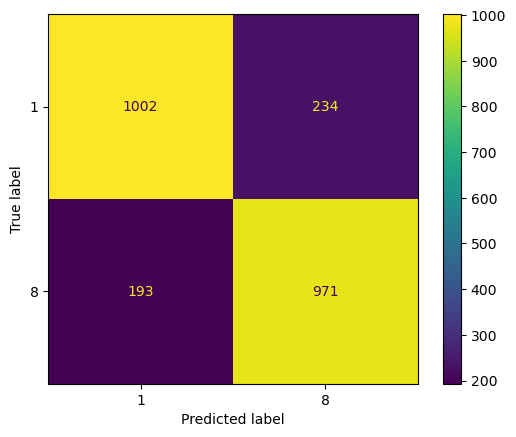

0.8220833333333334

In [27]:
from sklearn.linear_model import SGDClassifier
sgd_model = SGDClassifier(n_jobs=jobs, random_state=42)#, verbose=1)
train_and_test_model(sgd_model, X_train, X_test, y_train, y_test)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


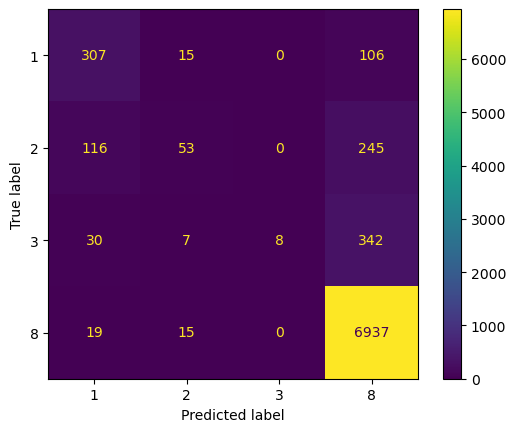

0.8908536585365854

In [20]:
from sklearn.svm import LinearSVC
svc_model = LinearSVC(random_state=42)#, verbose=1)
train_and_test_model(svc_model, X_train, X_test, y_train, y_test)


## Random Forest

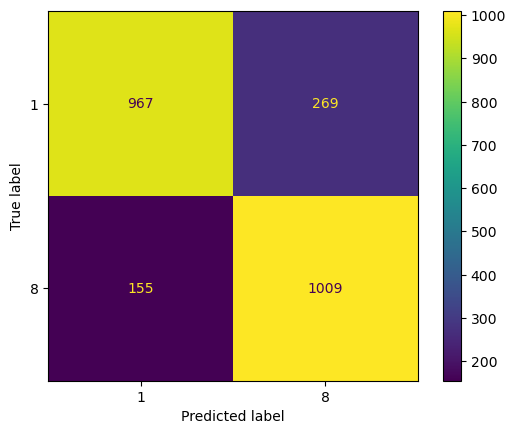

0.8233333333333334

In [28]:
from sklearn.ensemble import RandomForestClassifier

def calculate_min_entropy(sequence):
    sequence = np.asarray(sequence, dtype=float)  # Convert sequence to float
    p = np.mean(sequence)  # Proportion of ones
    max_prob = max(p, 1 - p)
    if max_prob == 0:  # Handle the case where all bits are the same
        return 0
    min_entropy = -np.log2(max_prob)
    return min_entropy




# Create the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42, n_jobs=jobs)
train_and_test_model(rf_model, X_train, X_test, y_train, y_test)




In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42, n_jobs=jobs)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],           # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt'],       # Number of features to consider when looking for the best split
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_rf = best_model.predict(X_test)

# Calculate the accuracy of the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)
print("Best Hyperparameters:", best_params)

# To Launch MLFlow UI open a terminal and run the following command - mlflow ui


Random Forest Accuracy: 0.82375
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


## Gradient Boosting

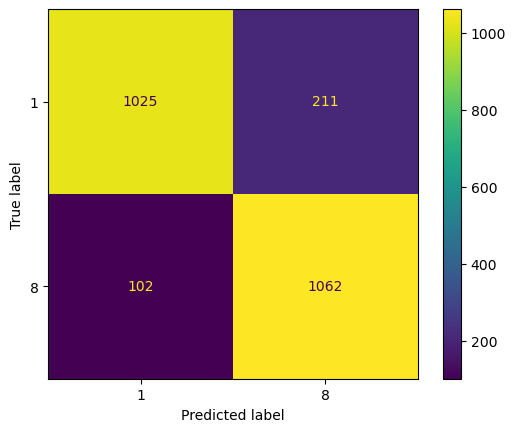

Gradient Boosting Accuracy: 0.8695833333333334


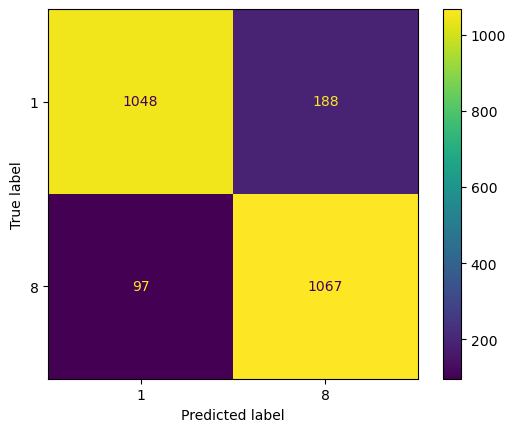

Hist Gradient Boosting Accuracy: 0.88125


In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier



with mlflow.start_run():
    # Initialize the model
    gb_model = GradientBoostingClassifier(random_state=42)
    hgb_model = HistGradientBoostingClassifier(random_state=42)

    # Calculate the accuracy of the Gradient Boosting model
    accuracy_gb = train_and_test_model(gb_model, X_train, X_test, y_train, y_test)

    # Log parameters and metrics
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", gb_model.n_estimators)
    mlflow.log_param("learning_rate", gb_model.learning_rate)
    mlflow.log_metric("accuracy", accuracy_gb)

    # Log the model
    mlflow.sklearn.log_model(gb_model, "gradient_boosting_model")

    # Print the accuracy
    print("Gradient Boosting Accuracy:", accuracy_gb)
    print("Hist Gradient Boosting Accuracy:", train_and_test_model(hgb_model, X_train, X_test, y_train, y_test))


GridSearch

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier



# Create the Gradient Boosting classifier
gb_model = GradientBoostingClassifier(random_state=42)


# Define the hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Perform Grid Search with cross-validation (cv=5) to find the best hyperparameters
grid_search = GridSearchCV(gb_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_gb = best_model.predict(X_test)

# Calculate the accuracy of the Gradient Boosting model with the best hyperparameters
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Best Hyperparameters:", best_params)
print("Gradient Boosting Accuracy:", accuracy_gb)


ValueError: Found input variables with inconsistent numbers of samples: [6400, 9600]

## XGBoost

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [0 3]

In [58]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


# Create the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Define the hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Map classes to [0, 1, 2]
y_train_mapped = y_train - 1  # This will change classes [1, 2, 3] to [0, 1, 2]

# Continue with the Grid Search
grid_search = GridSearchCV(xgb_model, param_grid, cv=5)
grid_search.fit(X_train, y_train_mapped)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set using the best XGBoost model
y_pred_xgb = best_xgb_model.predict(X_test)

# Calculate the accuracy of the XGBoost model with the best hyperparameters
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Best Hyperparameters for XGBoost:", best_params)
print("XGBoost Accuracy:", accuracy_xgb)


ValueError: 
All the 135 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 1471, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [0 3]


## CatBoost

In [6]:

import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=jobs, boosting_type='gbdt')
train_and_test_model(lgb_model, X_train, X_test, y_train, y_test)

: 

In [60]:
import lightgbm as lgb

# Create the LightGBM classifier
lgb_model = lgb.LGBMClassifier(random_state=42)

# Define the hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Perform Grid Search with cross-validation (cv=5) to find the best hyperparameters
grid_search = GridSearchCV(lgb_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_lgb_model = grid_search.best_estimator_

# Make predictions on the test set using the best LightGBM model
y_pred_lgb = best_lgb_model.predict(X_test)

# Calculate the accuracy of the LightGBM model with the best hyperparameters
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print("Best Hyperparameters for LightGBM:", best_params)
print("LightGBM Accuracy:", accuracy_lgb)


/opt/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## Neural Network

In [46]:
%%time
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

keras.utils.set_random_seed(42)

y_train_integer = y_train-1 #.astype('float32')
y_test_integer = y_test-1 #.astype('float32')

X_train_small, X_val, y_train_integer, y_val_integer = train_test_split(X_train, y_train_integer, test_size=0.2, random_state=42)
X_train_small = X_train_small.astype('float32')
X_val = X_val.astype('float32')

# Create the Neural Network model
nn_model = Sequential()
nn_model.add(Input(shape=(X_train_small.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(4, activation='softmax'))

# Compile the model
nn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train_small, y_train_integer, epochs=25, batch_size=64, validation_data=(X_val, y_val_integer), verbose=0)

# Make predictions on the test set
y_pred_probabilities = nn_model.predict(X_test.astype('float32'))
y_pred_nn = np.argmax(y_pred_probabilities, axis=-1)

# Calculate the accuracy of the Neural Network model
accuracy_nn = accuracy_score(y_test_integer, y_pred_nn)
print("Neural Network Accuracy:", accuracy_nn)
ConfusionMatrixDisplay.from_predictions(y_test_integer, y_pred_nn)
plt.show()
plt.close()


2024-06-13 14:09:05.086429: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


100/100 [==============================] - 0s 498us/step
Neural Network Accuracy: 0.7865625


NameError: name 'ConfusionMatrixDisplay' is not defined

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 16
num_classes = 4  # Labels are 1, 2, 3, 4
model = MLP(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)



num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    for i, (features, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels - 1)  # labels - 1 to convert to 0-based index
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for features, labels in test_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == (labels - 1)).sum().item()  # labels - 1 to convert to 0-based index

    print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')


Epoch [1/100], Loss: 0.4030
Epoch [2/100], Loss: 0.2550
Epoch [3/100], Loss: 0.4659
Epoch [4/100], Loss: 0.4976
Epoch [5/100], Loss: 0.3265
Epoch [6/100], Loss: 0.2392
Epoch [7/100], Loss: 0.2690
Epoch [8/100], Loss: 0.4503
Epoch [9/100], Loss: 0.3265
Epoch [10/100], Loss: 0.2888
Epoch [11/100], Loss: 0.3349
Epoch [12/100], Loss: 0.4263
Epoch [13/100], Loss: 0.2713
Epoch [14/100], Loss: 0.3613
Epoch [15/100], Loss: 0.3564
Epoch [16/100], Loss: 0.2610
Epoch [17/100], Loss: 0.3074
Epoch [18/100], Loss: 0.2276
Epoch [19/100], Loss: 0.3096
Epoch [20/100], Loss: 0.5256
Epoch [21/100], Loss: 0.2720
Epoch [22/100], Loss: 0.2485
Epoch [23/100], Loss: 0.1853
Epoch [24/100], Loss: 0.1641
Epoch [25/100], Loss: 0.2211
Epoch [26/100], Loss: 0.2175
Epoch [27/100], Loss: 0.3333
Epoch [28/100], Loss: 0.1698
Epoch [29/100], Loss: 0.1998
Epoch [30/100], Loss: 0.2045
Epoch [31/100], Loss: 0.3368
Epoch [32/100], Loss: 0.2244
Epoch [33/100], Loss: 0.1627
Epoch [34/100], Loss: 0.4418
Epoch [35/100], Loss: 0

## LSTM

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ... (Previous code for reading and preprocessing the data)

# Convert the data into numerical format
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Reshape the input data for LSTM
time_steps = 1  # Each sample is treated as a single time step
X_train_lstm = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])

# Create the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(time_steps, X_train.shape[1])))
lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dense(3, activation='sigmoid'))  # Assuming binary classification

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions on the test set
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = np.round(y_pred_lstm).astype(int).flatten()  # Convert probabilities to binary predictions

# Calculate the accuracy of the LSTM model
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print("LSTM Accuracy:", accuracy_lstm)


NameError: name 'X_train' is not defined